In [1]:
gene_familly = None

In [2]:
# Parameters
gene_familly = "CAMTA"


<div style="hwidth: 100%; background-color: #ddd; overflow:hidden; ">
    <div style="display: flex; justify-content: center; align-items: center; border-bottom: 10px solid #80c4e7; padding: 3px;">
        <h2 style="position: relative; top: 3px; left: 8px;">S2 Project: DNA Classification - (part2: Approach 2)</h2>
        <!--<img style="position: absolute; height: 68px; top: -2px;; right: 18px" src="./Content/Notebook-images/dna1.png"/>-->
    </div>
    <div style="padding: 3px 8px;">
        
1. <strong>Description</strong>:
   - In this approach, we represent DNA sequences using k-mer frequencies. Each sequence is encoded as a vector where each element represents the frequency of a specific k-mer in the sequence. This vector representation is then used as input to a neural network architecture for classification.

2. <strong>Pros</strong>:
   - Utilizes frequency analysis: By representing sequences based on the frequency of k-mers, the model can capture important patterns and motifs in the DNA sequences.
   - Flexible architecture: Neural networks provide a flexible framework for learning complex relationships between features, allowing the model to adapt to different types of data.

3. <strong>Cons</strong>:
   - Curse of dimensionality: Depending on the value of k and the size of the alphabet (e.g., DNA bases A, C, G, T), the feature space can become very large, leading to increased computational complexity and potential overfitting.
   - Loss of sequence information: By focusing solely on k-mer frequencies, the model may overlook important sequential dependencies and structural information present in the DNA sequences.
    </div>    
</div>

### 1 - Importing utils
The following code cells will import necessary libraries.

In [3]:
import os, random, string, itertools, warnings, sys, json
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from IPython.display import display, HTML
from sklearn.metrics import (
    confusion_matrix, 
    classification_report, 
    accuracy_score, 
    f1_score, 
    recall_score, 
    precision_score
)

from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import pad_sequences
from sklearn.feature_extraction import DictVectorizer
from keras.models import Sequential
from keras.layers import Dense, Input
from keras.layers import LSTM, SimpleRNN
from keras.layers import Flatten, Embedding, BatchNormalization, Dropout, MaxPooling1D, GlobalAveragePooling1D
from keras.preprocessing import sequence
from keras.layers import Conv1D

# OS
current_directory = os.getcwd()
root_directory = os.path.abspath(os.path.join(current_directory, os.pardir))
utils_directory = os.path.join(root_directory, 'processing')
sys.path.append(utils_directory)

# Import Utils
import fasta
from representation import DNA
from visualization import VISU, VISUReport

In [4]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  0


### 2 - Importing Dataset
The following function will read our preprocessed **.csv file** and return a pandas dataframe

In [5]:
# READ GENE_INFO JSON FILE

gene_info_path = "../data/gene_info.json"
dataset_path   = "../data/one_vs_other/"
with open(gene_info_path, 'r') as json_file:
    gene_info = json.load(json_file)

In [6]:
#gene_info
#gene_familly = "bHLH"

In [7]:
# FOCUS ON GENE FAMALLY

gene_dict = gene_info[gene_familly]
df_path = dataset_path+gene_dict['file_code']+".csv"

In [8]:
# READ DATASET

dataset_ = pd.read_csv(df_path)
#_, dataset = train_test_split(dataset_, test_size=0.02, stratify=dataset_['class'], random_state=42)
dataset = dataset_
dataset.head()

,id,sequence,length,class
0,Achn001091,MEVEIVSTETIKPSSPTPIHLKTFSLSLLDQLNAPVFSKLVYFYPH...,1485,1
1,Achn048091,MAESRRYGLGTQLDIEQILLEAQHRWLRPAEICEILRNFKKFRIAP...,1075,1
2,Achn059301,MLRNFRKDGHNWKKKKDGKTVKEAHEHLKNLDYEDDGNSRTLEHIV...,724,1
3,Achn102611,MAPGRSDVKSPEHGTPIVEEDFVVDGVDRLGIGSSSNEEEDGVQVT...,1220,1
4,Achn103241,MENIVPGRLEGWEIHGFRTMEDLDFGNILEEAKARWLRPNEIHAML...,757,1


In [9]:
report = VISUReport(gene_familly, dataset)

* **Model Utils**

In [10]:
domaine = "ACDEFGHIKLMNPQRSTVWYX"
def model_checkpoint(model_name):
    gene_familly_ = gene_familly.replace('/', '__')
    return tf.keras.callbacks.ModelCheckpoint(
        filepath="Output/Model/"+gene_familly_+"/"+model_name+".weights.h5", 
        monitor='val_loss', 
        verbose=0, 
        save_best_only=True, 
        save_weights_only=True
    )
def early_stopping(patience=10):
    return tf.keras.callbacks.EarlyStopping(
        monitor="val_accuracy",
        patience=patience,
        verbose=0,
    )

### 4 - Training and Testing

<h4 style="background-color: #80c4e6; display: flex;">
    <ul><li>k=2</li></ul>
</h4>

In [11]:
k = 2
X, y, features_k2 = DNA.build_kmer_representation_v2(dataset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_test.head()

,AA,AC,AD,AE,AF,AG,AH,AI,AK,AL,...,YN,YP,YQ,YR,YS,YT,YV,YW,YX,YY
2362,0.029451,0.000000,0.002677,0.004016,0.004016,0.006693,0.001339,0.002677,0.001339,0.004016,...,0.001339,0.001339,0.001339,0.002677,0.001339,0.001339,0.000000,0.000000,0.0,0.002677
951,0.004604,0.002762,0.004604,0.006446,0.000921,0.001842,0.004604,0.002762,0.000000,0.006446,...,0.000000,0.000921,0.000000,0.003683,0.002762,0.001842,0.000921,0.000921,0.0,0.000921
274,0.014085,0.000000,0.007042,0.004024,0.002012,0.003018,0.002012,0.006036,0.006036,0.003018,...,0.001006,0.001006,0.004024,0.006036,0.001006,0.003018,0.000000,0.001006,0.0,0.003018
329,0.000000,0.000000,0.000000,0.031746,0.000000,0.000000,0.000000,0.000000,0.000000,0.015873,...,0.000000,0.000000,0.015873,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
2240,0.000000,0.003484,0.000000,0.010453,0.000000,0.000000,0.000000,0.000000,0.010453,0.006969,...,0.003484,0.003484,0.000000,0.000000,0.003484,0.003484,0.003484,0.000000,0.0,0.003484


In [12]:
print("X_train:", X_train.shape)
print("X_test:", X_test.shape)
print("y_train:", y_train.shape)
print("y_test:", y_test.shape)

NUM_CLASS  = 1
SEQ_LENGTH = X_train.shape[1]

X_train: (2127, 441)
X_test: (532, 441)
y_train: (2127,)
y_test: (532,)


* <span style="color: blue; font-weight: bold;">MODEL 1 : FEED-FORWARD NETWORKS</span>

In [13]:
name="FEEDFORWARD_k2"
def feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):
    model = Sequential(name=name)
    model.add(Input(shape=(SEQ_LENGTH,)))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(num_output, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# Build & train the model
model = feedforward_net1()
stop_callback = early_stopping(patience=10)
save_callback = model_checkpoint(name)

X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)
history = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])

# Evaluate and score
test_scores = model.evaluate(X_test, y_test, verbose=0)
train_score = history.history.get('accuracy')[-1]
print("\n[Train Accuracy: {:.2f}% - Test Accuracy: {:.2f}%]".format(train_score*100, test_scores[1]*100))

Model: "FEEDFORWARD_k2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 256)                 │         113,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 156,417 (611.00 KB)

 Trainable params: 156,417 (611.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100


 1/27 ━━━━━━━━━━━━━━━━━━━━ 16s 636ms/step - accuracy: 0.5625 - loss: 0.6928

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7438 - loss: 0.6845   

27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7473 - loss: 0.6840 - val_accuracy: 0.9765 - val_loss: 0.5920


Epoch 2/100


 1/27 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9844 - loss: 0.5818

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9647 - loss: 0.5013 - val_accuracy: 0.9765 - val_loss: 0.1330


Epoch 3/100


 1/27 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 1.0000 - loss: 0.1172

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9841 - loss: 0.0996 - val_accuracy: 0.9836 - val_loss: 0.0498


Epoch 4/100


 1/27 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9844 - loss: 0.0246

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9888 - loss: 0.0386 - val_accuracy: 0.9836 - val_loss: 0.0444


Epoch 5/100


 1/27 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 1.0000 - loss: 0.0135

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9939 - loss: 0.0249 - val_accuracy: 0.9883 - val_loss: 0.0358


Epoch 6/100


 1/27 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 1.0000 - loss: 0.0147

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9914 - loss: 0.0247 - val_accuracy: 0.9836 - val_loss: 0.0485


Epoch 7/100


 1/27 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 1.0000 - loss: 0.0033

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9977 - loss: 0.0108 - val_accuracy: 0.9859 - val_loss: 0.0381


Epoch 8/100


 1/27 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 1.0000 - loss: 0.0048

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9987 - loss: 0.0069 - val_accuracy: 0.9859 - val_loss: 0.0496


Epoch 9/100


 1/27 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 1.0000 - loss: 0.0109

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9989 - loss: 0.0069 - val_accuracy: 0.9624 - val_loss: 0.1511


Epoch 10/100


 1/27 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9844 - loss: 0.0319

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9912 - loss: 0.0213 - val_accuracy: 0.9859 - val_loss: 0.0554


Epoch 11/100


 1/27 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 1.0000 - loss: 0.0010

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9970 - loss: 0.0074 - val_accuracy: 0.9859 - val_loss: 0.0444


Epoch 12/100


 1/27 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 1.0000 - loss: 0.0012

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9998 - loss: 0.0051 - val_accuracy: 0.9812 - val_loss: 0.0505


Epoch 13/100


 1/27 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 1.0000 - loss: 0.0019

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 0.0022 

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0022 - val_accuracy: 0.9859 - val_loss: 0.0547


Epoch 14/100


 1/27 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9844 - loss: 0.0185

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9977 - loss: 0.0048 

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9978 - loss: 0.0047 - val_accuracy: 0.9859 - val_loss: 0.0549


Epoch 15/100


 1/27 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 1.0000 - loss: 6.4457e-04

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 9.0805e-04 

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 9.1715e-04 - val_accuracy: 0.9812 - val_loss: 0.0532



[Train Accuracy: 100.00% - Test Accuracy: 98.68%]


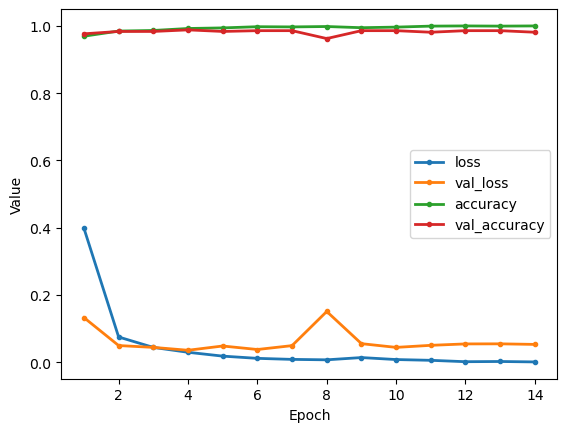

In [14]:
VISU.plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])

In [15]:
VISU.test_report(X_test, y_test, model=model,  args=[model.name, test_scores[1]*100]) 
report.add_report(X_test, y_test, model=model, history=history, args=[model.name, "---"])

 1/17 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 1/17 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 550us/step


<h4 style="background-color: #80c4e6; display: flex;">
    <ul><li>k=3</li></ul>
</h4>

In [16]:
k = 3
X, y, features_k3 = DNA.build_kmer_representation_v2(dataset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_test.head()

,AAA,AAC,AAD,AAE,AAF,AAG,AAH,AAI,AAK,AAL,...,YYN,YYP,YYQ,YYR,YYS,YYT,YYV,YYW,YYX,YYY
2362,0.012064,0.0,0.000000,0.0,0.001340,0.0,0.00134,0.001340,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
951,0.000922,0.0,0.000922,0.0,0.000000,0.0,0.00000,0.000922,0.0,0.000922,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
274,0.003021,0.0,0.002014,0.0,0.001007,0.0,0.00000,0.001007,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.001007,0.0,0.0,0.0,0.0
329,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.00000,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
2240,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.00000,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0


In [17]:
print("X_train:", X_train.shape)
print("X_test:", X_test.shape)
print("y_train:", y_train.shape)
print("y_test:", y_test.shape)

NUM_CLASS  = 1
SEQ_LENGTH = X_train.shape[1]

X_train: (2127, 8589)
X_test: (532, 8589)
y_train: (2127,)
y_test: (532,)


* <span style="color: blue; font-weight: bold;">MODEL 1 : FEED-FORWARD NETWORKS</span>

In [18]:
name="FEEDFORWARD_k3"
def feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):
    model = Sequential(name=name)
    model.add(Input(shape=(SEQ_LENGTH,)))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(num_output, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# Build & train the model
model = feedforward_net1()
stop_callback = early_stopping(patience=10)
save_callback = model_checkpoint(name)

X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)
history = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])

# Evaluate and score
test_scores = model.evaluate(X_test, y_test, verbose=0)
train_score = history.history.get('accuracy')[-1]
print("\n[Train Accuracy: {:.2f}% - Test Accuracy: {:.2f}%]".format(train_score*100, test_scores[1]*100))

Model: "FEEDFORWARD_k3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_5 (Dense)                      │ (None, 256)                 │       2,199,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,242,305 (8.55 MB)

 Trainable params: 2,242,305 (8.55 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100


 1/27 ━━━━━━━━━━━━━━━━━━━━ 16s 641ms/step - accuracy: 0.5469 - loss: 0.6931

 8/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5466 - loss: 0.6928   

16/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5799 - loss: 0.6918

24/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6350 - loss: 0.6891

27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.6585 - loss: 0.6869 - val_accuracy: 0.9859 - val_loss: 0.5906


Epoch 2/100


 1/27 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 1.0000 - loss: 0.5886

 8/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9924 - loss: 0.5652 

16/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9902 - loss: 0.5247

24/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9895 - loss: 0.4778

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9893 - loss: 0.4555 - val_accuracy: 0.9883 - val_loss: 0.0468


Epoch 3/100


 1/27 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9844 - loss: 0.0734

 9/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9951 - loss: 0.0376 

17/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9959 - loss: 0.0306

25/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9960 - loss: 0.0274

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9960 - loss: 0.0266 - val_accuracy: 0.9883 - val_loss: 0.0328


Epoch 4/100


 1/27 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 1.0000 - loss: 0.0024

 8/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9976 - loss: 0.0046 

16/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9982 - loss: 0.0056

24/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9982 - loss: 0.0057

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9982 - loss: 0.0057 - val_accuracy: 0.9930 - val_loss: 0.0157


Epoch 5/100


 1/27 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 1.0000 - loss: 0.0020

 9/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.0033 

17/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.0029

25/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.0026

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 0.0025 - val_accuracy: 0.9953 - val_loss: 0.0226


Epoch 6/100


 1/27 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 1.0000 - loss: 0.0019

 9/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.0012 

17/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.0011

25/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.0011

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 0.0011 - val_accuracy: 0.9953 - val_loss: 0.0154


Epoch 7/100


 1/27 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 1.0000 - loss: 5.4885e-04

 9/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 5.2502e-04 

17/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 5.4124e-04

25/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 5.3370e-04

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 5.2683e-04 - val_accuracy: 0.9953 - val_loss: 0.0170


Epoch 8/100


 1/27 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 1.0000 - loss: 1.9536e-04

 9/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 4.6701e-04 

17/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 4.8456e-04

25/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 4.8480e-04

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 1.0000 - loss: 4.8075e-04 - val_accuracy: 0.9953 - val_loss: 0.0153


Epoch 9/100


 1/27 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 1.0000 - loss: 3.1955e-04

 9/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9993 - loss: 9.4962e-04 

17/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9991 - loss: 0.0013    

25/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9991 - loss: 0.0013

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9992 - loss: 0.0013 - val_accuracy: 0.9953 - val_loss: 0.0153


Epoch 10/100


 1/27 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 1.0000 - loss: 1.7889e-04

 9/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.2317e-04 

17/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.5736e-04

25/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.6882e-04

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 2.7036e-04 - val_accuracy: 0.9953 - val_loss: 0.0169


Epoch 11/100


 1/27 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 1.0000 - loss: 1.1918e-04

 9/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.3431e-04 

17/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.4484e-04

25/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.5671e-04

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 1.0000 - loss: 1.6130e-04 - val_accuracy: 0.9953 - val_loss: 0.0146


Epoch 12/100


 1/27 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 1.0000 - loss: 5.2705e-05

 8/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 3.0337e-04 

16/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 3.2085e-04

24/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.9842e-04

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 2.8840e-04 - val_accuracy: 0.9953 - val_loss: 0.0149


Epoch 13/100


 1/27 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 1.0000 - loss: 2.9784e-05

 9/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 8.6535e-05 

17/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.1825e-04

25/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.2706e-04

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 1.2772e-04 - val_accuracy: 0.9977 - val_loss: 0.0141


Epoch 14/100


 1/27 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 1.0000 - loss: 1.7755e-04

 8/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.2869e-04 

16/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.5339e-04

24/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.4877e-04

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 1.4630e-04 - val_accuracy: 0.9977 - val_loss: 0.0144


Epoch 15/100


 1/27 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 1.0000 - loss: 3.1916e-05

 9/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 8.4109e-05 

17/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.0035e-04

25/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.0107e-04

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 1.0044e-04 - val_accuracy: 0.9953 - val_loss: 0.0162


Epoch 16/100


 1/27 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 1.0000 - loss: 1.9860e-05

 9/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 3.3144e-05 

17/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 4.0320e-05

25/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 4.6509e-05

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 4.8710e-05 - val_accuracy: 0.9953 - val_loss: 0.0153


Epoch 17/100


 1/27 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 1.0000 - loss: 2.0407e-05

 9/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.9138e-05 

17/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 3.4857e-05

25/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 3.7682e-05

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 3.8352e-05 - val_accuracy: 0.9977 - val_loss: 0.0147


Epoch 18/100


 1/27 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 1.0000 - loss: 3.9404e-05

 9/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 4.9241e-05 

17/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 5.1362e-05

25/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 5.3031e-05

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 5.3648e-05 - val_accuracy: 0.9953 - val_loss: 0.0171


Epoch 19/100


 1/27 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 1.0000 - loss: 1.9882e-05

 9/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 9.4962e-05 

17/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 7.9105e-05

25/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 7.1641e-05

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 6.9425e-05 - val_accuracy: 0.9953 - val_loss: 0.0161


Epoch 20/100


 1/27 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 1.0000 - loss: 1.3041e-05

 9/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 5.5928e-05 

17/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 8.2888e-05

25/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 9.1144e-05

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 9.2512e-05 - val_accuracy: 0.9953 - val_loss: 0.0125


Epoch 21/100


 1/27 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 1.0000 - loss: 6.2861e-05

 9/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 5.0559e-05 

17/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 4.8178e-05

25/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 4.7817e-05

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 4.7571e-05 - val_accuracy: 0.9977 - val_loss: 0.0137


Epoch 22/100


 1/27 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 1.0000 - loss: 1.7257e-05

 9/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.6160e-05 

17/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.7463e-05

25/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.8708e-05

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 2.9005e-05 - val_accuracy: 0.9977 - val_loss: 0.0154


Epoch 23/100


 1/27 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 1.0000 - loss: 1.2311e-05

 9/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 3.4563e-05 

17/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 3.7152e-05

25/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 3.6421e-05

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 3.6114e-05 - val_accuracy: 0.9977 - val_loss: 0.0144



[Train Accuracy: 100.00% - Test Accuracy: 99.44%]


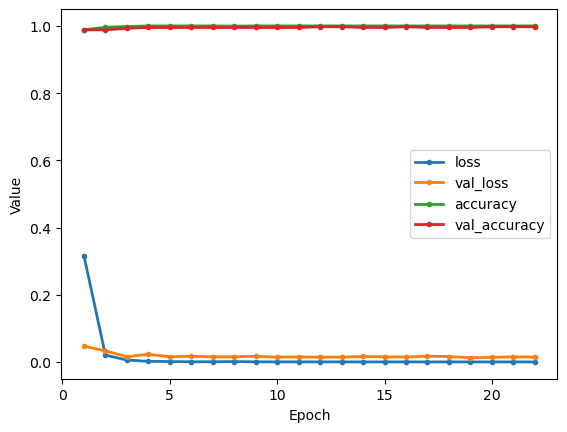

In [19]:
VISU.plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])

In [20]:
VISU.test_report(X_test, y_test, model=model,  args=[model.name, test_scores[1]*100]) 
report.add_report(X_test, y_test, model=model, history=history, args=[model.name, "---"])

 1/17 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 1/17 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


<h4 style="background-color: #80c4e6; display: flex;">
    <ul><li>k=4</li></ul>
</h4>

In [21]:
k = 4
X, y, features_k4 = DNA.build_kmer_representation_v2(dataset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_test.head()

,AAAA,AAAC,AAAD,AAAE,AAAF,AAAG,AAAH,AAAI,AAAK,AAAL,...,YYYM,YYYN,YYYP,YYYQ,YYYR,YYYS,YYYT,YYYV,YYYX,YYYY
2362,0.005369,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
951,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000923,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
274,0.001008,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
329,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2240,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [22]:
NUM_CLASS  = 1
SEQ_LENGTH = X_train.shape[1]

* <span style="color: blue; font-weight: bold;">MODEL 2 : FEED-FORWARD NETWORKS</span>

In [23]:
name="FEEDFORWARD_k4"
def feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):
    model = Sequential(name=name)
    model.add(Input(shape=(SEQ_LENGTH,)))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(num_output, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# Build & train the model
model = feedforward_net1()
stop_callback = early_stopping(patience=10)
save_callback = model_checkpoint(name)

X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)
history = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])


# Evaluate and score
test_scores = model.evaluate(X_test, y_test, verbose=0)
train_score = history.history.get('accuracy')[-1]
print("\n[Train Accuracy: {:.2f}% - Test Accuracy: {:.2f}%]".format(train_score*100, test_scores[1]*100))

Model: "FEEDFORWARD_k4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_10 (Dense)                     │ (None, 256)                 │      33,357,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 33,398,273 (127.40 MB)

 Trainable params: 33,398,273 (127.40 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100


 1/27 ━━━━━━━━━━━━━━━━━━━━ 22s 863ms/step - accuracy: 0.4688 - loss: 0.6932

 2/27 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - accuracy: 0.4844 - loss: 0.6931  

 3/27 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - accuracy: 0.4826 - loss: 0.6931

 4/27 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - accuracy: 0.4821 - loss: 0.6931

 5/27 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - accuracy: 0.4813 - loss: 0.6931

 6/27 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - accuracy: 0.4796 - loss: 0.6931

 7/27 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - accuracy: 0.4803 - loss: 0.6930

 8/27 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - accuracy: 0.4820 - loss: 0.6929

 9/27 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - accuracy: 0.4833 - loss: 0.6928

10/27 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - accuracy: 0.4842 - loss: 0.6927

11/27 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - accuracy: 0.4852 - loss: 0.6926

12/27 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - accuracy: 0.4856 - loss: 0.6925

13/27 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - accuracy: 0.4866 - loss: 0.6923

14/27 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - accuracy: 0.4887 - loss: 0.6922

15/27 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.4919 - loss: 0.6920

16/27 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.4961 - loss: 0.6919

17/27 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.5010 - loss: 0.6917

18/27 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.5066 - loss: 0.6915

19/27 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.5125 - loss: 0.6912

20/27 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.5187 - loss: 0.6910

21/27 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.5252 - loss: 0.6907

22/27 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.5317 - loss: 0.6904

23/27 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.5383 - loss: 0.6901

24/27 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.5449 - loss: 0.6897

25/27 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.5514 - loss: 0.6893

26/27 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.5579 - loss: 0.6889

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.5640 - loss: 0.6885

27/27 ━━━━━━━━━━━━━━━━━━━━ 4s 119ms/step - accuracy: 0.5697 - loss: 0.6881 - val_accuracy: 0.9930 - val_loss: 0.6160


Epoch 2/100


 1/27 ━━━━━━━━━━━━━━━━━━━━ 5s 205ms/step - accuracy: 0.9844 - loss: 0.6221

 2/27 ━━━━━━━━━━━━━━━━━━━━ 2s 92ms/step - accuracy: 0.9883 - loss: 0.6186 

 3/27 ━━━━━━━━━━━━━━━━━━━━ 2s 87ms/step - accuracy: 0.9905 - loss: 0.6159

 4/27 ━━━━━━━━━━━━━━━━━━━━ 1s 84ms/step - accuracy: 0.9919 - loss: 0.6127

 5/27 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step - accuracy: 0.9929 - loss: 0.6096

 6/27 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step - accuracy: 0.9936 - loss: 0.6062

 7/27 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - accuracy: 0.9942 - loss: 0.6027

 8/27 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - accuracy: 0.9947 - loss: 0.5989

 9/27 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - accuracy: 0.9951 - loss: 0.5952

10/27 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - accuracy: 0.9954 - loss: 0.5914

11/27 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - accuracy: 0.9957 - loss: 0.5876

12/27 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - accuracy: 0.9960 - loss: 0.5838

13/27 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - accuracy: 0.9962 - loss: 0.5799

14/27 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - accuracy: 0.9964 - loss: 0.5759

15/27 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 0.9965 - loss: 0.5719

16/27 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 0.9966 - loss: 0.5676

17/27 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 0.9967 - loss: 0.5633

18/27 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 0.9968 - loss: 0.5590

19/27 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 0.9968 - loss: 0.5546

20/27 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 0.9969 - loss: 0.5501

21/27 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.9970 - loss: 0.5456

22/27 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.9970 - loss: 0.5410

23/27 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.9970 - loss: 0.5364

24/27 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.9971 - loss: 0.5317

25/27 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.9971 - loss: 0.5270

26/27 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.9970 - loss: 0.5223

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.9970 - loss: 0.5178

27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 97ms/step - accuracy: 0.9969 - loss: 0.5135 - val_accuracy: 0.9883 - val_loss: 0.1269


Epoch 3/100


 1/27 ━━━━━━━━━━━━━━━━━━━━ 3s 143ms/step - accuracy: 1.0000 - loss: 0.0984

 2/27 ━━━━━━━━━━━━━━━━━━━━ 2s 91ms/step - accuracy: 1.0000 - loss: 0.0925 

 3/27 ━━━━━━━━━━━━━━━━━━━━ 2s 89ms/step - accuracy: 1.0000 - loss: 0.0898

 4/27 ━━━━━━━━━━━━━━━━━━━━ 1s 87ms/step - accuracy: 1.0000 - loss: 0.0876

 5/27 ━━━━━━━━━━━━━━━━━━━━ 1s 84ms/step - accuracy: 0.9994 - loss: 0.0860

 6/27 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step - accuracy: 0.9990 - loss: 0.0841

 7/27 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step - accuracy: 0.9989 - loss: 0.0821

 8/27 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - accuracy: 0.9985 - loss: 0.0803

 9/27 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - accuracy: 0.9983 - loss: 0.0784

10/27 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - accuracy: 0.9982 - loss: 0.0766

11/27 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - accuracy: 0.9979 - loss: 0.0749

12/27 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - accuracy: 0.9977 - loss: 0.0734

13/27 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - accuracy: 0.9975 - loss: 0.0720

14/27 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - accuracy: 0.9973 - loss: 0.0707

15/27 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 0.9971 - loss: 0.0694

16/27 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 0.9970 - loss: 0.0682

17/27 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 0.9969 - loss: 0.0670

18/27 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 0.9968 - loss: 0.0658

19/27 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.9968 - loss: 0.0647

20/27 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.9967 - loss: 0.0636

21/27 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.9967 - loss: 0.0625

22/27 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.9967 - loss: 0.0615

23/27 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.9967 - loss: 0.0605

24/27 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.9967 - loss: 0.0595

25/27 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.9967 - loss: 0.0586

26/27 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.9966 - loss: 0.0579

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.9966 - loss: 0.0572

27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 94ms/step - accuracy: 0.9965 - loss: 0.0565 - val_accuracy: 0.9906 - val_loss: 0.0289


Epoch 4/100


 1/27 ━━━━━━━━━━━━━━━━━━━━ 3s 144ms/step - accuracy: 1.0000 - loss: 0.0053

 2/27 ━━━━━━━━━━━━━━━━━━━━ 2s 94ms/step - accuracy: 1.0000 - loss: 0.0052 

 3/27 ━━━━━━━━━━━━━━━━━━━━ 2s 91ms/step - accuracy: 1.0000 - loss: 0.0057

 4/27 ━━━━━━━━━━━━━━━━━━━━ 2s 88ms/step - accuracy: 1.0000 - loss: 0.0058

 5/27 ━━━━━━━━━━━━━━━━━━━━ 1s 84ms/step - accuracy: 1.0000 - loss: 0.0060

 6/27 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step - accuracy: 1.0000 - loss: 0.0061

 7/27 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step - accuracy: 1.0000 - loss: 0.0061

 8/27 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step - accuracy: 1.0000 - loss: 0.0062

 9/27 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - accuracy: 1.0000 - loss: 0.0063

10/27 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - accuracy: 1.0000 - loss: 0.0063

11/27 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - accuracy: 1.0000 - loss: 0.0063

12/27 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - accuracy: 1.0000 - loss: 0.0063

13/27 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - accuracy: 1.0000 - loss: 0.0063

14/27 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - accuracy: 1.0000 - loss: 0.0063

15/27 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 1.0000 - loss: 0.0062

16/27 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 0.9999 - loss: 0.0063

17/27 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 0.9999 - loss: 0.0063

18/27 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 0.9998 - loss: 0.0062

19/27 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 0.9998 - loss: 0.0062

20/27 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 0.9998 - loss: 0.0062

21/27 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.9998 - loss: 0.0062

22/27 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.9997 - loss: 0.0062

23/27 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.9997 - loss: 0.0062

24/27 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.9997 - loss: 0.0061

25/27 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.9997 - loss: 0.0061

26/27 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.9997 - loss: 0.0061

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.9997 - loss: 0.0061

27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 91ms/step - accuracy: 0.9997 - loss: 0.0061 - val_accuracy: 0.9906 - val_loss: 0.0226


Epoch 5/100


 1/27 ━━━━━━━━━━━━━━━━━━━━ 3s 126ms/step - accuracy: 1.0000 - loss: 0.0029

 2/27 ━━━━━━━━━━━━━━━━━━━━ 2s 89ms/step - accuracy: 1.0000 - loss: 0.0026 

 3/27 ━━━━━━━━━━━━━━━━━━━━ 2s 87ms/step - accuracy: 1.0000 - loss: 0.0025

 4/27 ━━━━━━━━━━━━━━━━━━━━ 1s 85ms/step - accuracy: 1.0000 - loss: 0.0024

 5/27 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step - accuracy: 1.0000 - loss: 0.0025

 6/27 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step - accuracy: 1.0000 - loss: 0.0025

 7/27 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step - accuracy: 1.0000 - loss: 0.0025

 8/27 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - accuracy: 1.0000 - loss: 0.0025

 9/27 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - accuracy: 1.0000 - loss: 0.0024

10/27 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - accuracy: 1.0000 - loss: 0.0024

11/27 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - accuracy: 1.0000 - loss: 0.0024

12/27 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - accuracy: 1.0000 - loss: 0.0023

13/27 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - accuracy: 1.0000 - loss: 0.0023

14/27 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - accuracy: 1.0000 - loss: 0.0023

15/27 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 1.0000 - loss: 0.0023

16/27 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 1.0000 - loss: 0.0022

17/27 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 1.0000 - loss: 0.0022

18/27 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 1.0000 - loss: 0.0022

19/27 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 1.0000 - loss: 0.0022

20/27 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 1.0000 - loss: 0.0022

21/27 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 1.0000 - loss: 0.0022

22/27 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 1.0000 - loss: 0.0021

23/27 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 1.0000 - loss: 0.0021

24/27 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 1.0000 - loss: 0.0021

25/27 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 1.0000 - loss: 0.0021

26/27 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 1.0000 - loss: 0.0021

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 1.0000 - loss: 0.0021

27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 84ms/step - accuracy: 1.0000 - loss: 0.0021 - val_accuracy: 0.9883 - val_loss: 0.0269


Epoch 6/100


 1/27 ━━━━━━━━━━━━━━━━━━━━ 2s 93ms/step - accuracy: 1.0000 - loss: 9.5382e-04

 2/27 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - accuracy: 1.0000 - loss: 0.0010    

 3/27 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - accuracy: 1.0000 - loss: 0.0014

 4/27 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - accuracy: 1.0000 - loss: 0.0015

 5/27 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - accuracy: 1.0000 - loss: 0.0016

 6/27 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - accuracy: 1.0000 - loss: 0.0016

 7/27 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - accuracy: 1.0000 - loss: 0.0017

 8/27 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - accuracy: 1.0000 - loss: 0.0017

 9/27 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - accuracy: 1.0000 - loss: 0.0017

10/27 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - accuracy: 1.0000 - loss: 0.0017

11/27 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - accuracy: 1.0000 - loss: 0.0017

12/27 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - accuracy: 1.0000 - loss: 0.0017

13/27 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - accuracy: 1.0000 - loss: 0.0016

14/27 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 1.0000 - loss: 0.0016

15/27 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 1.0000 - loss: 0.0016

16/27 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 1.0000 - loss: 0.0016

17/27 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 1.0000 - loss: 0.0016

18/27 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 1.0000 - loss: 0.0016

19/27 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 1.0000 - loss: 0.0016

20/27 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 1.0000 - loss: 0.0016

21/27 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 1.0000 - loss: 0.0016

22/27 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 1.0000 - loss: 0.0016

23/27 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 1.0000 - loss: 0.0015

24/27 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 1.0000 - loss: 0.0015

25/27 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 1.0000 - loss: 0.0015

26/27 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 1.0000 - loss: 0.0015

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 1.0000 - loss: 0.0015

27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 89ms/step - accuracy: 1.0000 - loss: 0.0015 - val_accuracy: 0.9906 - val_loss: 0.0194


Epoch 7/100


 1/27 ━━━━━━━━━━━━━━━━━━━━ 3s 132ms/step - accuracy: 1.0000 - loss: 0.0017

 2/27 ━━━━━━━━━━━━━━━━━━━━ 2s 92ms/step - accuracy: 1.0000 - loss: 0.0016 

 3/27 ━━━━━━━━━━━━━━━━━━━━ 2s 89ms/step - accuracy: 1.0000 - loss: 0.0016

 4/27 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step - accuracy: 1.0000 - loss: 0.0015

 5/27 ━━━━━━━━━━━━━━━━━━━━ 1s 84ms/step - accuracy: 1.0000 - loss: 0.0014

 6/27 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step - accuracy: 1.0000 - loss: 0.0013

 7/27 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step - accuracy: 1.0000 - loss: 0.0013

 8/27 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - accuracy: 1.0000 - loss: 0.0012

 9/27 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - accuracy: 1.0000 - loss: 0.0012

10/27 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - accuracy: 1.0000 - loss: 0.0011

11/27 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - accuracy: 1.0000 - loss: 0.0011

12/27 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - accuracy: 1.0000 - loss: 0.0011

13/27 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - accuracy: 1.0000 - loss: 0.0011

14/27 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - accuracy: 1.0000 - loss: 0.0010

15/27 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 1.0000 - loss: 0.0010

16/27 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 1.0000 - loss: 0.0010

17/27 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 1.0000 - loss: 9.9972e-04

18/27 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 1.0000 - loss: 9.8590e-04

19/27 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 1.0000 - loss: 9.7231e-04

20/27 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 1.0000 - loss: 9.5966e-04

21/27 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 1.0000 - loss: 9.4765e-04

22/27 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 1.0000 - loss: 9.3635e-04

23/27 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 1.0000 - loss: 9.2554e-04

24/27 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 1.0000 - loss: 9.1548e-04

25/27 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 1.0000 - loss: 9.0597e-04

26/27 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 1.0000 - loss: 8.9760e-04

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 1.0000 - loss: 8.8963e-04

27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 83ms/step - accuracy: 1.0000 - loss: 8.8222e-04 - val_accuracy: 0.9883 - val_loss: 0.0267


Epoch 8/100


 1/27 ━━━━━━━━━━━━━━━━━━━━ 2s 95ms/step - accuracy: 1.0000 - loss: 2.4350e-04

 2/27 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - accuracy: 1.0000 - loss: 3.1375e-04

 3/27 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - accuracy: 1.0000 - loss: 3.4191e-04

 4/27 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - accuracy: 1.0000 - loss: 3.5436e-04

 5/27 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - accuracy: 1.0000 - loss: 3.5627e-04

 6/27 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - accuracy: 1.0000 - loss: 3.5842e-04

 7/27 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - accuracy: 1.0000 - loss: 3.6153e-04

 8/27 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - accuracy: 1.0000 - loss: 3.6134e-04

 9/27 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - accuracy: 1.0000 - loss: 3.6150e-04

10/27 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - accuracy: 1.0000 - loss: 3.6143e-04

11/27 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - accuracy: 1.0000 - loss: 3.6149e-04

12/27 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - accuracy: 1.0000 - loss: 3.6246e-04

13/27 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - accuracy: 1.0000 - loss: 3.6224e-04

14/27 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 1.0000 - loss: 3.6143e-04

15/27 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 1.0000 - loss: 3.6089e-04

16/27 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 1.0000 - loss: 3.5975e-04

17/27 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 1.0000 - loss: 3.6701e-04

18/27 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 1.0000 - loss: 3.7296e-04

19/27 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 1.0000 - loss: 3.7772e-04

20/27 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 1.0000 - loss: 3.9442e-04

21/27 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 1.0000 - loss: 4.0851e-04

22/27 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 1.0000 - loss: 4.2051e-04

23/27 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 1.0000 - loss: 4.3080e-04

24/27 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 1.0000 - loss: 4.3966e-04

25/27 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 1.0000 - loss: 4.4744e-04

26/27 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 1.0000 - loss: 4.5452e-04

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 1.0000 - loss: 4.6104e-04

27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 91ms/step - accuracy: 1.0000 - loss: 4.6710e-04 - val_accuracy: 0.9953 - val_loss: 0.0162


Epoch 9/100


 1/27 ━━━━━━━━━━━━━━━━━━━━ 3s 134ms/step - accuracy: 1.0000 - loss: 6.7424e-04

 2/27 ━━━━━━━━━━━━━━━━━━━━ 2s 93ms/step - accuracy: 1.0000 - loss: 5.7484e-04 

 3/27 ━━━━━━━━━━━━━━━━━━━━ 2s 89ms/step - accuracy: 1.0000 - loss: 5.4173e-04

 4/27 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step - accuracy: 1.0000 - loss: 5.4430e-04

 5/27 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step - accuracy: 1.0000 - loss: 5.3771e-04

 6/27 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step - accuracy: 1.0000 - loss: 5.3096e-04

 7/27 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - accuracy: 1.0000 - loss: 5.2211e-04

 8/27 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - accuracy: 1.0000 - loss: 5.1613e-04

 9/27 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - accuracy: 1.0000 - loss: 5.1161e-04

10/27 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - accuracy: 1.0000 - loss: 5.0731e-04

11/27 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - accuracy: 1.0000 - loss: 5.0280e-04

12/27 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - accuracy: 1.0000 - loss: 5.0043e-04

13/27 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - accuracy: 1.0000 - loss: 4.9765e-04

14/27 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - accuracy: 1.0000 - loss: 4.9575e-04

15/27 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 1.0000 - loss: 4.9300e-04

16/27 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 1.0000 - loss: 4.9060e-04

17/27 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 1.0000 - loss: 4.8846e-04

18/27 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 1.0000 - loss: 4.8598e-04

19/27 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 1.0000 - loss: 4.8283e-04

20/27 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 1.0000 - loss: 4.7959e-04

21/27 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 1.0000 - loss: 4.7616e-04

22/27 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 1.0000 - loss: 4.7277e-04

23/27 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 1.0000 - loss: 4.6935e-04

24/27 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 1.0000 - loss: 4.6643e-04

25/27 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 1.0000 - loss: 4.6333e-04

26/27 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 1.0000 - loss: 4.6034e-04

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 1.0000 - loss: 4.5745e-04

27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 83ms/step - accuracy: 1.0000 - loss: 4.5476e-04 - val_accuracy: 0.9883 - val_loss: 0.0238


Epoch 10/100


 1/27 ━━━━━━━━━━━━━━━━━━━━ 2s 94ms/step - accuracy: 1.0000 - loss: 1.5747e-04

 2/27 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - accuracy: 1.0000 - loss: 1.6950e-04

 3/27 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - accuracy: 1.0000 - loss: 1.6781e-04

 4/27 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - accuracy: 1.0000 - loss: 1.6842e-04

 5/27 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - accuracy: 1.0000 - loss: 1.6852e-04

 6/27 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - accuracy: 1.0000 - loss: 1.6897e-04

 7/27 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - accuracy: 1.0000 - loss: 1.6905e-04

 8/27 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - accuracy: 1.0000 - loss: 1.6911e-04

 9/27 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - accuracy: 1.0000 - loss: 1.6920e-04

10/27 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - accuracy: 1.0000 - loss: 1.6939e-04

11/27 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - accuracy: 1.0000 - loss: 1.7973e-04

12/27 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - accuracy: 1.0000 - loss: 1.8712e-04

13/27 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - accuracy: 1.0000 - loss: 1.9260e-04

14/27 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 1.0000 - loss: 2.0038e-04

15/27 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 1.0000 - loss: 2.0669e-04

16/27 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 1.0000 - loss: 2.1200e-04

17/27 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 1.0000 - loss: 2.1618e-04

18/27 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 1.0000 - loss: 2.1959e-04

19/27 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 1.0000 - loss: 2.2241e-04

20/27 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 1.0000 - loss: 2.2464e-04

21/27 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 1.0000 - loss: 2.2650e-04

22/27 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 1.0000 - loss: 2.2814e-04

23/27 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 1.0000 - loss: 2.2974e-04

24/27 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 1.0000 - loss: 2.3111e-04

25/27 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 1.0000 - loss: 2.3220e-04

26/27 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 1.0000 - loss: 2.3306e-04

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 1.0000 - loss: 2.3381e-04

27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - accuracy: 1.0000 - loss: 2.3452e-04 - val_accuracy: 0.9906 - val_loss: 0.0225


Epoch 11/100


 1/27 ━━━━━━━━━━━━━━━━━━━━ 2s 93ms/step - accuracy: 1.0000 - loss: 1.2158e-04

 2/27 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - accuracy: 1.0000 - loss: 1.5330e-04

 3/27 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - accuracy: 1.0000 - loss: 1.6483e-04

 4/27 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - accuracy: 1.0000 - loss: 1.8690e-04

 5/27 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - accuracy: 1.0000 - loss: 1.9565e-04

 6/27 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - accuracy: 1.0000 - loss: 1.9871e-04

 7/27 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - accuracy: 1.0000 - loss: 2.0246e-04

 8/27 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - accuracy: 1.0000 - loss: 2.0361e-04

 9/27 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - accuracy: 1.0000 - loss: 2.0489e-04

10/27 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - accuracy: 1.0000 - loss: 2.0473e-04

11/27 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - accuracy: 1.0000 - loss: 2.0359e-04

12/27 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - accuracy: 1.0000 - loss: 2.0209e-04

13/27 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - accuracy: 1.0000 - loss: 2.0089e-04

14/27 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 1.0000 - loss: 2.0051e-04

15/27 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 1.0000 - loss: 2.0025e-04

16/27 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 1.0000 - loss: 1.9980e-04

17/27 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 1.0000 - loss: 1.9929e-04

18/27 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 1.0000 - loss: 1.9867e-04

19/27 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 1.0000 - loss: 1.9805e-04

20/27 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 1.0000 - loss: 1.9728e-04

21/27 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 1.0000 - loss: 1.9632e-04

22/27 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 1.0000 - loss: 1.9567e-04

23/27 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 1.0000 - loss: 1.9496e-04

24/27 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 1.0000 - loss: 1.9412e-04

25/27 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 1.0000 - loss: 1.9331e-04

26/27 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 1.0000 - loss: 1.9253e-04

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 1.0000 - loss: 1.9174e-04

27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - accuracy: 1.0000 - loss: 1.9100e-04 - val_accuracy: 0.9883 - val_loss: 0.0235


Epoch 12/100


 1/27 ━━━━━━━━━━━━━━━━━━━━ 2s 92ms/step - accuracy: 1.0000 - loss: 2.1831e-04

 2/27 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - accuracy: 1.0000 - loss: 1.9119e-04

 3/27 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - accuracy: 1.0000 - loss: 1.8619e-04

 4/27 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - accuracy: 1.0000 - loss: 1.7818e-04

 5/27 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - accuracy: 1.0000 - loss: 1.7702e-04

 6/27 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - accuracy: 1.0000 - loss: 1.7498e-04

 7/27 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - accuracy: 1.0000 - loss: 1.7494e-04

 8/27 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - accuracy: 1.0000 - loss: 1.7347e-04

 9/27 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - accuracy: 1.0000 - loss: 1.7110e-04

10/27 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - accuracy: 1.0000 - loss: 1.6964e-04

11/27 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - accuracy: 1.0000 - loss: 1.6821e-04

12/27 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - accuracy: 1.0000 - loss: 1.6646e-04

13/27 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - accuracy: 1.0000 - loss: 1.6480e-04

14/27 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 1.0000 - loss: 1.6331e-04

15/27 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 1.0000 - loss: 1.6435e-04

16/27 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 1.0000 - loss: 1.6504e-04

17/27 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 1.0000 - loss: 1.6570e-04

18/27 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 1.0000 - loss: 1.6602e-04

19/27 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 1.0000 - loss: 1.6650e-04

20/27 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 1.0000 - loss: 1.6672e-04

21/27 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 1.0000 - loss: 1.6684e-04

22/27 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 1.0000 - loss: 1.6682e-04

23/27 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 1.0000 - loss: 1.6666e-04

24/27 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 1.0000 - loss: 1.6634e-04

25/27 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 1.0000 - loss: 1.6611e-04

26/27 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 1.0000 - loss: 1.6593e-04

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 1.0000 - loss: 1.6600e-04

27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - accuracy: 1.0000 - loss: 1.6608e-04 - val_accuracy: 0.9883 - val_loss: 0.0243


Epoch 13/100


 1/27 ━━━━━━━━━━━━━━━━━━━━ 2s 93ms/step - accuracy: 1.0000 - loss: 1.8579e-04

 2/27 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - accuracy: 1.0000 - loss: 1.5825e-04

 3/27 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - accuracy: 1.0000 - loss: 1.4397e-04

 4/27 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - accuracy: 1.0000 - loss: 1.3302e-04

 5/27 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - accuracy: 1.0000 - loss: 1.2738e-04

 6/27 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - accuracy: 1.0000 - loss: 1.2289e-04

 7/27 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - accuracy: 1.0000 - loss: 1.2038e-04

 8/27 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - accuracy: 1.0000 - loss: 1.1760e-04

 9/27 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - accuracy: 1.0000 - loss: 1.1657e-04

10/27 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - accuracy: 1.0000 - loss: 1.1544e-04

11/27 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - accuracy: 1.0000 - loss: 1.1503e-04

12/27 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - accuracy: 1.0000 - loss: 1.1457e-04

13/27 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - accuracy: 1.0000 - loss: 1.1403e-04

14/27 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 1.0000 - loss: 1.1340e-04

15/27 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 1.0000 - loss: 1.1275e-04

16/27 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 1.0000 - loss: 1.1259e-04

17/27 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 1.0000 - loss: 1.1275e-04

18/27 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 1.0000 - loss: 1.1284e-04

19/27 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 1.0000 - loss: 1.1282e-04

20/27 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 1.0000 - loss: 1.1273e-04

21/27 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 1.0000 - loss: 1.1254e-04

22/27 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 1.0000 - loss: 1.1237e-04

23/27 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 1.0000 - loss: 1.1210e-04

24/27 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 1.0000 - loss: 1.1178e-04

25/27 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 1.0000 - loss: 1.1143e-04

26/27 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 1.0000 - loss: 1.1137e-04

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 1.0000 - loss: 1.1131e-04

27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - accuracy: 1.0000 - loss: 1.1125e-04 - val_accuracy: 0.9883 - val_loss: 0.0279


Epoch 14/100


 1/27 ━━━━━━━━━━━━━━━━━━━━ 2s 94ms/step - accuracy: 1.0000 - loss: 7.1720e-05

 2/27 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - accuracy: 1.0000 - loss: 1.1427e-04

 3/27 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - accuracy: 1.0000 - loss: 1.1544e-04

 4/27 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - accuracy: 1.0000 - loss: 1.1628e-04

 5/27 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - accuracy: 1.0000 - loss: 1.1934e-04

 6/27 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - accuracy: 1.0000 - loss: 1.1967e-04

 7/27 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - accuracy: 1.0000 - loss: 1.1981e-04

 8/27 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - accuracy: 1.0000 - loss: 1.1866e-04

 9/27 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - accuracy: 1.0000 - loss: 1.1718e-04

10/27 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - accuracy: 1.0000 - loss: 1.1536e-04

11/27 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - accuracy: 1.0000 - loss: 1.1351e-04

12/27 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - accuracy: 1.0000 - loss: 1.1142e-04

13/27 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - accuracy: 1.0000 - loss: 1.1043e-04

14/27 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 1.0000 - loss: 1.0969e-04

15/27 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 1.0000 - loss: 1.0884e-04

16/27 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 1.0000 - loss: 1.0805e-04

17/27 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 1.0000 - loss: 1.0710e-04

18/27 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 1.0000 - loss: 1.0624e-04

19/27 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 1.0000 - loss: 1.0553e-04

20/27 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 1.0000 - loss: 1.0494e-04

21/27 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 1.0000 - loss: 1.0429e-04

22/27 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 1.0000 - loss: 1.0368e-04

23/27 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 1.0000 - loss: 1.0318e-04

24/27 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 1.0000 - loss: 1.0271e-04

25/27 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 1.0000 - loss: 1.0219e-04

26/27 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 1.0000 - loss: 1.0166e-04

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 1.0000 - loss: 1.0113e-04

27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - accuracy: 1.0000 - loss: 1.0064e-04 - val_accuracy: 0.9883 - val_loss: 0.0270


Epoch 15/100


 1/27 ━━━━━━━━━━━━━━━━━━━━ 2s 94ms/step - accuracy: 1.0000 - loss: 7.6601e-05

 2/27 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - accuracy: 1.0000 - loss: 8.0424e-05

 3/27 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - accuracy: 1.0000 - loss: 7.5783e-05

 4/27 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - accuracy: 1.0000 - loss: 7.3528e-05

 5/27 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - accuracy: 1.0000 - loss: 7.0828e-05

 6/27 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - accuracy: 1.0000 - loss: 6.8656e-05

 7/27 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - accuracy: 1.0000 - loss: 6.7496e-05

 8/27 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - accuracy: 1.0000 - loss: 6.6531e-05

 9/27 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - accuracy: 1.0000 - loss: 6.5920e-05

10/27 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - accuracy: 1.0000 - loss: 6.7376e-05

11/27 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - accuracy: 1.0000 - loss: 6.8413e-05

12/27 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - accuracy: 1.0000 - loss: 6.9116e-05

13/27 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - accuracy: 1.0000 - loss: 6.9561e-05

14/27 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 1.0000 - loss: 6.9799e-05

15/27 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 1.0000 - loss: 7.0090e-05

16/27 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 1.0000 - loss: 7.0221e-05

17/27 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 1.0000 - loss: 7.0382e-05

18/27 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 1.0000 - loss: 7.0438e-05

19/27 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 1.0000 - loss: 7.0390e-05

20/27 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 1.0000 - loss: 7.0411e-05

21/27 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 1.0000 - loss: 7.0353e-05

22/27 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 1.0000 - loss: 7.0220e-05

23/27 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 1.0000 - loss: 7.0029e-05

24/27 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 1.0000 - loss: 6.9804e-05

25/27 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 1.0000 - loss: 6.9620e-05

26/27 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 1.0000 - loss: 6.9434e-05

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 1.0000 - loss: 6.9260e-05

27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - accuracy: 1.0000 - loss: 6.9098e-05 - val_accuracy: 0.9883 - val_loss: 0.0277


Epoch 16/100


 1/27 ━━━━━━━━━━━━━━━━━━━━ 2s 95ms/step - accuracy: 1.0000 - loss: 5.9728e-05

 2/27 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - accuracy: 1.0000 - loss: 5.7910e-05

 3/27 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - accuracy: 1.0000 - loss: 5.7057e-05

 4/27 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - accuracy: 1.0000 - loss: 5.7921e-05

 5/27 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - accuracy: 1.0000 - loss: 5.9848e-05

 6/27 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - accuracy: 1.0000 - loss: 6.1298e-05

 7/27 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - accuracy: 1.0000 - loss: 6.2150e-05

 8/27 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - accuracy: 1.0000 - loss: 6.2600e-05

 9/27 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - accuracy: 1.0000 - loss: 6.2711e-05

10/27 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - accuracy: 1.0000 - loss: 6.5163e-05

11/27 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - accuracy: 1.0000 - loss: 6.6738e-05

12/27 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - accuracy: 1.0000 - loss: 6.7628e-05

13/27 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - accuracy: 1.0000 - loss: 6.8068e-05

14/27 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 1.0000 - loss: 6.8226e-05

15/27 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 1.0000 - loss: 6.8318e-05

16/27 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 1.0000 - loss: 6.8258e-05

17/27 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 1.0000 - loss: 6.8081e-05

18/27 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 1.0000 - loss: 6.7816e-05

19/27 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 1.0000 - loss: 6.7506e-05

20/27 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 1.0000 - loss: 6.7223e-05

21/27 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 1.0000 - loss: 6.7176e-05

22/27 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 1.0000 - loss: 6.7088e-05

23/27 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 1.0000 - loss: 6.6993e-05

24/27 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 1.0000 - loss: 6.6983e-05

25/27 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 1.0000 - loss: 6.6932e-05

26/27 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 1.0000 - loss: 6.6852e-05

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 1.0000 - loss: 6.6770e-05

27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - accuracy: 1.0000 - loss: 6.6693e-05 - val_accuracy: 0.9883 - val_loss: 0.0271


Epoch 17/100


 1/27 ━━━━━━━━━━━━━━━━━━━━ 2s 94ms/step - accuracy: 1.0000 - loss: 6.0653e-05

 2/27 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - accuracy: 1.0000 - loss: 5.3782e-05

 3/27 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - accuracy: 1.0000 - loss: 4.9448e-05

 4/27 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - accuracy: 1.0000 - loss: 4.7323e-05

 5/27 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - accuracy: 1.0000 - loss: 4.7781e-05

 6/27 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - accuracy: 1.0000 - loss: 4.9724e-05

 7/27 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - accuracy: 1.0000 - loss: 5.0590e-05

 8/27 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - accuracy: 1.0000 - loss: 5.1580e-05

 9/27 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - accuracy: 1.0000 - loss: 5.2016e-05

10/27 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - accuracy: 1.0000 - loss: 5.2133e-05

11/27 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - accuracy: 1.0000 - loss: 5.2053e-05

12/27 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - accuracy: 1.0000 - loss: 5.1846e-05

13/27 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - accuracy: 1.0000 - loss: 5.2354e-05

14/27 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 1.0000 - loss: 5.2656e-05

15/27 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 1.0000 - loss: 5.2796e-05

16/27 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 1.0000 - loss: 5.2838e-05

17/27 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 1.0000 - loss: 5.2827e-05

18/27 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 1.0000 - loss: 5.2770e-05

19/27 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 1.0000 - loss: 5.2667e-05

20/27 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 1.0000 - loss: 5.2649e-05

21/27 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 1.0000 - loss: 5.2583e-05

22/27 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 1.0000 - loss: 5.2684e-05

23/27 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 1.0000 - loss: 5.2755e-05

24/27 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 1.0000 - loss: 5.2786e-05

25/27 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 1.0000 - loss: 5.2779e-05

26/27 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 1.0000 - loss: 5.2750e-05

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 1.0000 - loss: 5.2777e-05

27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - accuracy: 1.0000 - loss: 5.2802e-05 - val_accuracy: 0.9883 - val_loss: 0.0289


Epoch 18/100


 1/27 ━━━━━━━━━━━━━━━━━━━━ 2s 93ms/step - accuracy: 1.0000 - loss: 1.9004e-05

 2/27 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - accuracy: 1.0000 - loss: 2.4430e-05

 3/27 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - accuracy: 1.0000 - loss: 3.3027e-05

 4/27 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - accuracy: 1.0000 - loss: 3.5716e-05

 5/27 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - accuracy: 1.0000 - loss: 3.7302e-05

 6/27 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - accuracy: 1.0000 - loss: 3.8566e-05

 7/27 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - accuracy: 1.0000 - loss: 3.8773e-05

 8/27 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - accuracy: 1.0000 - loss: 3.8767e-05

 9/27 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - accuracy: 1.0000 - loss: 3.8724e-05

10/27 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - accuracy: 1.0000 - loss: 3.8677e-05

11/27 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - accuracy: 1.0000 - loss: 3.8667e-05

12/27 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - accuracy: 1.0000 - loss: 3.8609e-05

13/27 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - accuracy: 1.0000 - loss: 3.8679e-05

14/27 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 1.0000 - loss: 3.8656e-05

15/27 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 1.0000 - loss: 3.8572e-05

16/27 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 1.0000 - loss: 3.8494e-05

17/27 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 1.0000 - loss: 3.8389e-05

18/27 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 1.0000 - loss: 3.8471e-05

19/27 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 1.0000 - loss: 3.8572e-05

20/27 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 1.0000 - loss: 3.8607e-05

21/27 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 1.0000 - loss: 3.8612e-05

22/27 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 1.0000 - loss: 3.8687e-05

23/27 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 1.0000 - loss: 3.8771e-05

24/27 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 1.0000 - loss: 3.8941e-05

25/27 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 1.0000 - loss: 3.9051e-05

26/27 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 1.0000 - loss: 3.9128e-05

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 1.0000 - loss: 3.9212e-05

27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - accuracy: 1.0000 - loss: 3.9290e-05 - val_accuracy: 0.9883 - val_loss: 0.0297



[Train Accuracy: 100.00% - Test Accuracy: 99.25%]


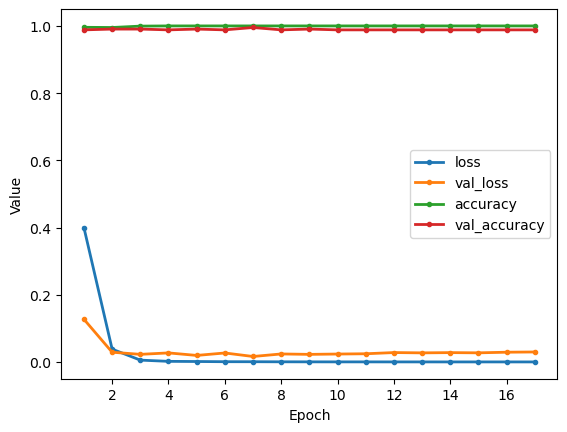

In [24]:
VISU.plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])

In [25]:
VISU.test_report(X_test, y_test, model=model,  args=[model.name, test_scores[1]*100]) 
report.add_report(X_test, y_test, model=model, history=history, args=[model.name, "---"])

 1/17 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step

 6/17 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step

11/17 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step

16/17 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


 1/17 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step

 6/17 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step

11/17 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step

16/17 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


In [26]:
report.save()

Report saved as Output/Reports/CAMTA/report_PVGWG9XL.html


<h4 style="background-color: #80c4e6; display: flex;">
    <ul><li>k=5</li></ul>
</h4>

In [27]:
#k = 5
#X, y, features_k5 = DNA.build_kmer_representation_v1(dataset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False)
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
#X_test.head()

In [28]:
#NUM_CLASS  = 1
#SEQ_LENGTH = X_train.shape[1]

* <span style="color: blue; font-weight: bold;">MODEL 3 : FEED-FORWARD NETWORKS</span>

In [29]:
"""
name="FEEDFORWARD_k5"
def feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):
    model = Sequential(name=name)
    model.add(Input(shape=(SEQ_LENGTH,)))
    model.add(Dense(2*256, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(num_output, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# Build & train the model
model = feedforward_net1()
stop_callback = early_stopping(patience=10)
save_callback = model_checkpoint(name)

X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)
history = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])


# Evaluate and score
test_scores = model.evaluate(X_test, y_test, verbose=0)
train_score = history.history.get('accuracy')[-1]
print("\n[Train Accuracy: {:.2f}% - Test Accuracy: {:.2f}%]".format(train_score*100, test_scores[1]*100))"""

'\nname="FEEDFORWARD_k5"\ndef feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):\n    model = Sequential(name=name)\n    model.add(Input(shape=(SEQ_LENGTH,)))\n    model.add(Dense(2*256, activation=\'relu\'))\n    model.add(Dropout(rate=0.2))\n    model.add(Dense(128, activation=\'relu\'))\n    model.add(Dropout(rate=0.2))\n    model.add(Dense(64, activation=\'relu\'))\n    model.add(Dropout(rate=0.2))\n    model.add(Dense(num_output, activation=\'sigmoid\'))\n    model.compile(loss=\'binary_crossentropy\', optimizer=\'adam\', metrics=[\'accuracy\'])\n    model.summary()\n    return model\n\n# Build & train the model\nmodel = feedforward_net1()\nstop_callback = early_stopping(patience=10)\nsave_callback = model_checkpoint(name)\n\nX_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)\nhistory = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])\n\n\n# Evaluate an

In [30]:
#VISU.plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])

In [31]:
#VISU.test_report(X_test, y_test, model=model,  args=[model.name, test_scores[1]*100]) 
#report.add_report(X_test, y_test, model=model, history=history, args=[model.name, "---"])
#report.save()

In [32]:
# END

In [33]:
###################################### DEBUG TO OPTIMIZE K-MER LOEADER FUNCTION ###########################################